<a href="https://colab.research.google.com/github/zzcn23/ZoeCannprojecr.ipynb/blob/main/Zoe_CannU4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

For my project I decided to use the provided data and model rebounds by player because Mr. Arredondo reccomended it and I think he knows a lot more about data science than me. I was going to do a voter turnout model but I couldn't find enough data for my sub groups.

In [2]:
#load the baskteball data from my github page.
url_bball = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv'

bball_data = pd.read_csv(url_bball)

In [5]:
bball_data

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


Since that's a lot of data and I don't want all of that because it will give me way too many divergences, I took out players who have less than 300 minutes played with a query

In [42]:
# Extract only the 'Pos' (Player Position) and 'TRB' (Total Rebounds) columns and then take out the combo positions to reduce divergences (and not get 900+)
rp_data=bball_data.query('MP <= 300')


Then I extracted only the positions and total rebounds data because that's all I'm analyzing and took out the combo positions so I only had 5

In [43]:
rp_data = bball_data[['Pos', 'TRB']]
rp_data = rp_data[~rp_data['Pos'].str.contains('-')]


In [44]:
#isn't this prettier and nicer
rp_data

,Pos,TRB
1,C,737
2,SG,216
3,PF,352
4,SG,167
5,SG,295
...,...,...
567,PF,103
568,PG,149
569,C,208
570,C,112


Next I made the positions categorical to make the data easier to analyze and group

In [45]:
#convert positions column to categorical data
rp_data['Pos'] = rp_data['Pos'].astype('category')

#store each position in 'pos_idx'
pos_idx = rp_data['Pos'].cat.codes.values

#make labels
pos_codes = rp_data['Pos'].cat.categories
#make dictionary
rebound_coords = {"pos": pos_codes}

This block of text is my hyperpriors, priors, and likelihood.

My hyperpriors define the distribution of rebounds across all positions and players- setting a baseline. I used 200 for mu in studentT because I felt like the total rebounds average would be around there. I set nu as 3 because I don't know a ton about basketball stats and wanted to make the distribution more robust to possible outliers. I set sigma as 100 because I wanted to give it a wide range of potential averages.


I used Student T because I previously used Poisson which didn't work as well and made some funky graphs. Student T also is pretty flexibe and I wanted to allow room for variance and outliers without giving them too much weight.

In [54]:
with pm.Model(coords=rebound_coords) as rebound_model:
    # Hyperpriors for baseline rebound parameters (global mean and standard deviation)
    μ_mu = pm.StudentT('μ_mu', mu=200, nu=3, sigma=100)
    μ_sd = pm.HalfStudentT('μ_sd', nu=3, sigma=10)

    # Position-level priors for mean and standard deviation of rebounds
    μ = pm.StudentT('μ', nu=3, mu=μ_mu, sigma=μ_sd, dims="pos")
    σ = pm.HalfStudentT('σ', sigma=100, nu=3, dims="pos")

    # Likelihood for the observed total rebounds (TRB)
    y = pm.StudentT('y', nu=3, mu=μ[pos_idx], sigma=σ[pos_idx], observed=rp_data['TRB'])

    # sampling
    idata_rebounds = pm.sample(target_accept=0.95)

Output()

Output()

Then I made the samples

In [61]:
pm.sample_posterior_predictive(idata_rebounds, model=rebound_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

And made some graphs for fun

array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_mu'}>,
        <Axes: title={'center': 'μ_mu'}>],
       [<Axes: title={'center': 'μ_sd'}>,
        <Axes: title={'center': 'μ_sd'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

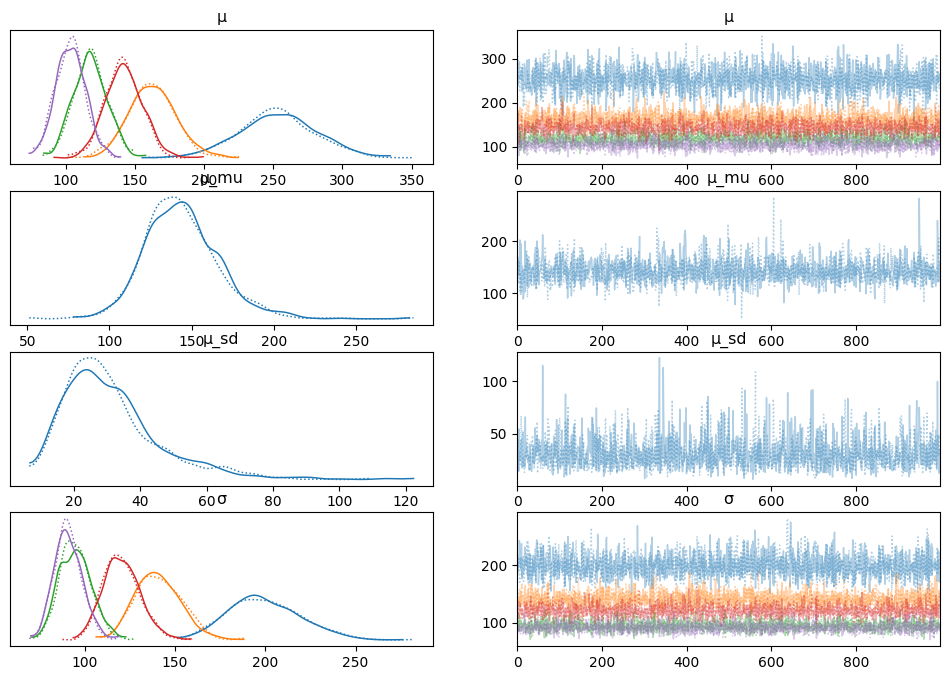

In [57]:
az.plot_trace(idata_rebounds)

Here's my ridge plot

array([<Axes: >], dtype=object)

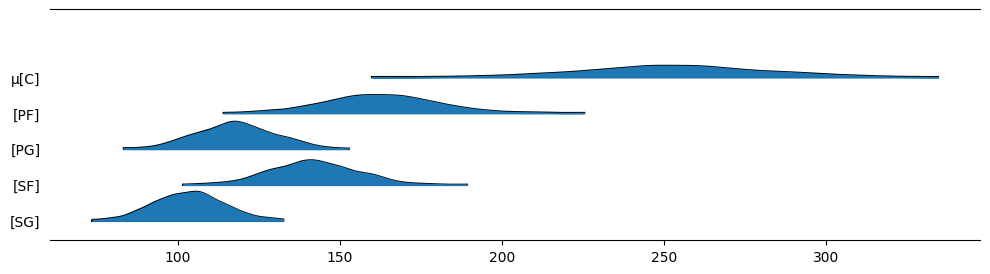

In [56]:
az.plot_forest(idata_rebounds, var_names=['μ'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

And posterior predictive

<Axes: xlabel='y'>

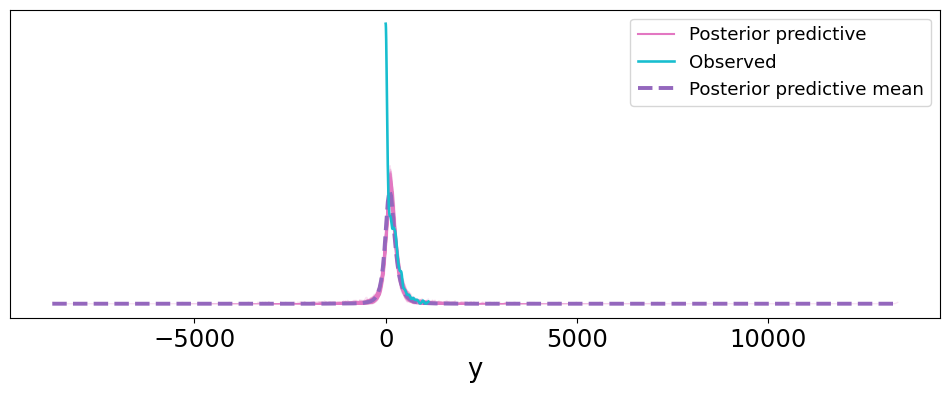

In [63]:
az.plot_ppc(idata_rebounds, num_pp_samples=200, figsize=(12, 4), colors=["C6", "C19", "C4"])

Looking at my ridge plots I think my results make a lot of sense. The centers have the most rebounds with around 250  with some variation. Centers typically get the most rebounds because of their height and close position to the basket. Then the forwards had around 150 which also checks out because they play near the basket and are tasked with both scoring and rebounding. Guards had the least at around 100 because guards play further from the basket.

My posterior predictive looks accurate too with a spike around 100-200 and a short tail to the right. It does have a negative side that my data doesnt have though.

Overall I think the hierarchal model with hyperpriors stabilizes rebound estimates and pulls the data towards the global mean.


If I did this project again I would analyze more categories besides rebounds and look at how minutes played compared to total rebounds to make my model more accurate

